In [13]:
import math

file_content = [line.split("\t") for line in open("../gold_standard_sentences/expression.tsv")]
headers = file_content[0]
data = file_content[1:]

In [14]:
cleaned_data = []
for row in data:
    # when the sentence does not contain any result, the type of result is always null
    # to discuss:
    # 5. type of statement - summary statement needs to be included as a class
    if row[2]:
        cleaned_data.append([*row[0:3], "c_elegans" if row[5] != "" else "mixed" if row[6] != "" else "other", "positive" if row[22] != "" else "negative" if row[23] != "" else "both" if row[24] != "" else "neutral", 0 if row[14] != "" else 1 if row[15] != "" else 2 if row[16] != "" else 3 if row[17] != "" else 4 if row[18] != "" else 5 if row[19] != "" else 6 if row[20] != "" else 7])

cleaned_headers = ["pmid", "wb_paper_id", "sentence", "species", "result_type", "class"]


In [15]:
from random import shuffle


def read_sentences_from_file_with_papid(filepath, min_sent_length=20):
    return [(sent.split("\t")[0], s) for sent in open(filepath) if len(s:=sent.split("\t")[1]) > min_sent_length]

neg_sent_otherexpr = read_sentences_from_file_with_papid("../extracted_sentences/neg_sentences_otherexpr.txt")
shuffle(neg_sent_otherexpr)

cleaned_data.extend(["", "WBPaper" + row[0], row[1], "", "", 8] for row in neg_sent_otherexpr[0:500])

In [16]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [17]:
corpus = embedder.encode([row[2] for row in cleaned_data], convert_to_tensor=True)

In [18]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_2d = umap_reducer.fit_transform(corpus)

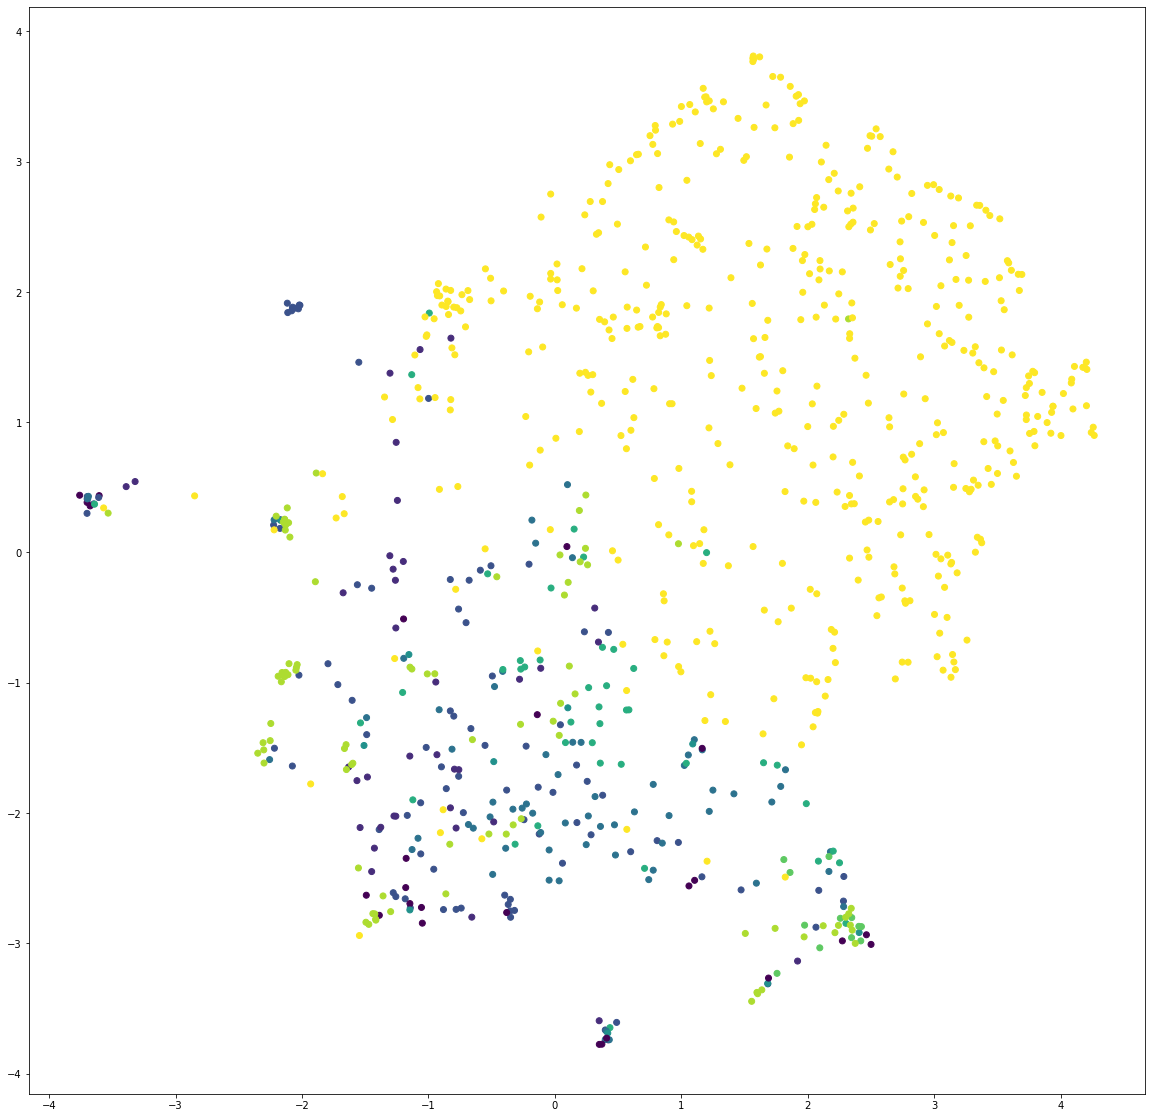

In [19]:
from matplotlib import pyplot as plt

colors = [row[5] for row in cleaned_data]
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(corpus_2d[:,0]), y=list(corpus_2d[:,1]), c=colors)

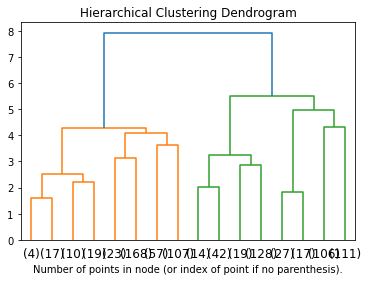

In [20]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data
X = corpus

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# precision and recall using clustering with n_clusters = 2

In [ ]:
model_fixed = AgglomerativeClustering(n_clusters=2)
model_fixed = model_fixed.fit(X)
tp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] == 2])
tn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] != 2])
fp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] != 2])
fn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] == 2])
precision_curatable_only = tp / (tp + fp)
recall_curatable_only = tp / (tp + fn)

tp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] != 8])
tn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] == 8])
fp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] == 8])
fn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] != 8])
precision_any_class = tp / (tp + fp)
recall_any_class = tp / (tp + fn)

tp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] < 7])
tn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] > 6])
fp = len([1 for index, label in enumerate(model_fixed.labels_) if label == 1 and cleaned_data[index][5] > 6])
fn = len([1 for index, label in enumerate(model_fixed.labels_) if label == 0 and cleaned_data[index][5] < 7])
precision_no_language = tp / (tp + fp)
recall_no_language = tp / (tp + fn)

# classifiers

In [98]:
from sklearn.neural_network import MLPClassifier
import math

converted_corpus = corpus.numpy()
indices = [i for i in range(len(corpus))]
shuffle(indices)
training_size = math.ceil(len(corpus) * 0.8)
training_indices = indices[0:training_size]
test_indices = indices[training_size:]
training_set_data = [converted_corpus[index] for index in training_indices]
test_set_classes = [cleaned_data[index][5] for index in test_indices]
base_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

# prediction
## multiclass

In [102]:
from sklearn.metrics import precision_recall_fscore_support as score
training_set_classes = [cleaned_data[index][5] for index in training_indices]
test_set_data = [converted_corpus[index] for index in test_indices]
clf = base_clf.fit(training_set_data, training_set_classes)
test_predictions = list(clf.predict(test_set_data))
precision, recall, fscore, support = score(test_set_classes, test_predictions, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.599125136697391
recall: 0.6763005780346821
fscore: 0.6248768013638423
support: None


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## binary
### all classes of gold standard sentences considered positive

In [104]:
training_set_classes = [1 if cleaned_data[index][5] != 8 else 0 for index in training_indices]
test_set_classes = [1 if cleaned_data[index][5] != 8 else 0 for index in test_indices]
clf = base_clf.fit(training_set_data, training_set_classes)

test_predictions = list(clf.predict(test_set_data))
precision, recall, fscore, support = score(test_set_classes, test_predictions)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.9537037  0.95384615]
recall: [0.97169811 0.92537313]
fscore: [0.96261682 0.93939394]
support: [106  67]


### all classes but negative for curation and negative sentences

In [106]:
training_set_classes = [1 if cleaned_data[index][5] < 7 else 0 for index in training_indices]
test_set_classes = [1 if cleaned_data[index][5] < 7 else 0 for index in test_indices]
clf = base_clf.fit(training_set_data, training_set_classes)

test_predictions = list(clf.predict(test_set_data))
precision, recall, fscore, support = score(test_set_classes, test_predictions)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.96581197 0.875     ]
recall: [0.94166667 0.9245283 ]
fscore: [0.9535865  0.89908257]
support: [120  53]


### only directly reports experimental results as positive

In [107]:
training_set_classes = [1 if cleaned_data[index][5] == 2 else 0 for index in training_indices]
test_set_classes = [1 if cleaned_data[index][5] == 2 else 0 for index in test_indices]
clf = base_clf.fit(training_set_data, training_set_classes)

test_predictions = list(clf.predict(test_set_data))
precision, recall, fscore, support = score(test_set_classes, test_predictions)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.95483871 0.5       ]
recall: [0.94267516 0.5625    ]
fscore: [0.94871795 0.52941176]
support: [157  16]
